In [33]:
import numpy as np
import requests
from PIL import Image
from scipy.misc import imread 
import io
import skimage.filters
import scipy.misc

In [16]:
url = "http://imagej.net/_images/thumb/2/29/Win.png/129px-Win.png"

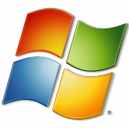

In [42]:
im = requests.get(url).content
im = io.BytesIO(im)
im = Image.open(im)
im

In [43]:
np.array(im)

array([[[0, 0, 0, 2],
        [0, 0, 0, 2],
        [0, 0, 0, 2],
        ..., 
        [0, 0, 0, 0],
        [0, 0, 0, 2],
        [0, 0, 0, 0]],

       [[0, 0, 0, 2],
        [0, 0, 0, 0],
        [0, 0, 0, 2],
        ..., 
        [0, 0, 0, 0],
        [0, 0, 0, 2],
        [0, 0, 0, 0]],

       [[0, 0, 0, 2],
        [0, 0, 0, 0],
        [0, 0, 0, 2],
        ..., 
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ..., 
       [[0, 0, 0, 2],
        [0, 0, 0, 2],
        [0, 0, 0, 2],
        ..., 
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 2],
        [0, 0, 0, 2],
        [0, 0, 0, 0],
        ..., 
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 2],
        [0, 0, 0, 0],
        [0, 0, 0, 2],
        ..., 
        [0, 0, 0, 0],
        [0, 0, 0, 2],
        [0, 0, 0, 0]]], dtype=uint8)

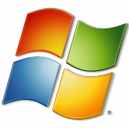

In [44]:
Image.fromarray(np.array(im))

In [1]:
url = "https://github.com/yoavram/Py4Eng/raw/master/data/Kobe_Bryant_2014.jpg"
filename = "../data/Kobe_Bryant_2014.jpg"

In [110]:
def download_image(url, mode="L"):
    data = requests.get(url).content
    bytesio = io.BytesIO(data)
    return scipy.misc.imread(bytesio, mode=mode)

def open_image(filename, mode="L"):
    return scipy.misc.imread(filename, mode=mode)

def save_image(filename, image):
    scipy.misc.imsave(filename, image)

def display_image(image):
    return Image.fromarray(image)
    
def segment(image):
    th = skimage.filters.threshold_otsu(image)
    segmented = np.zeros_like(image)
    segmented[image > th] = 255
    return segmented

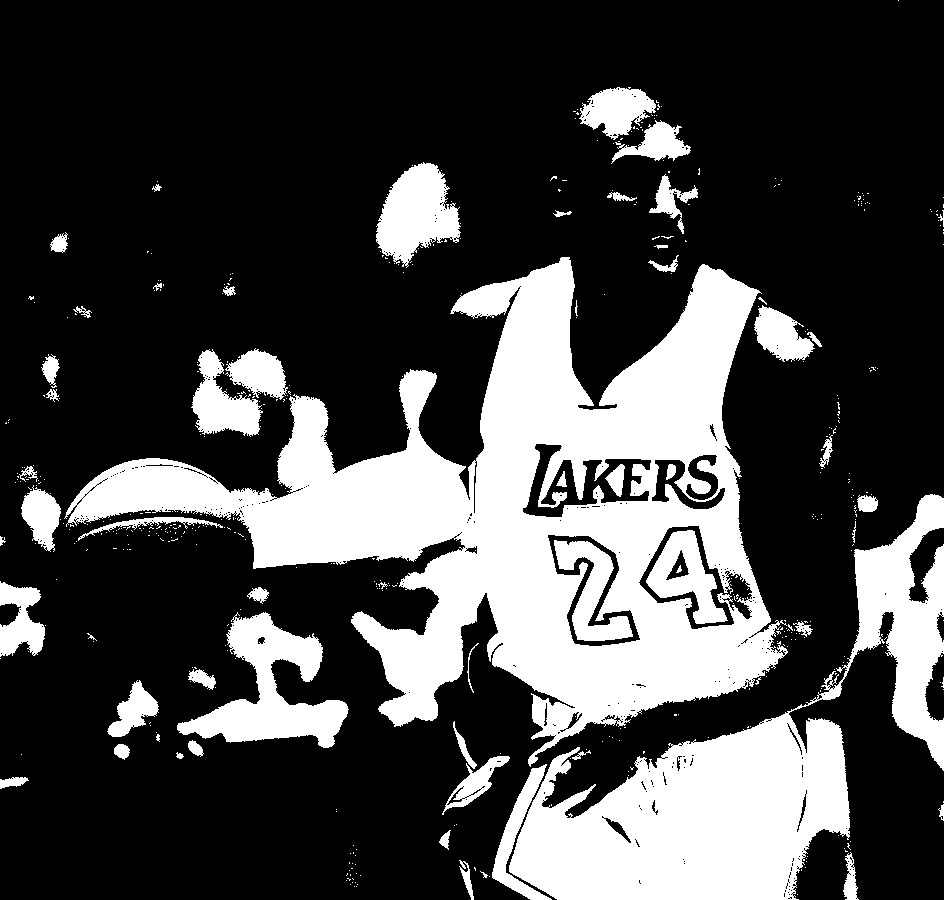

In [111]:
image = segment(open_image(filename))
display_image(image)

In [108]:
save_image('tmp.jpg', image)

# Click

http://click.pocoo.org/6/

In [13]:
%%file segment.py
import io

import numpy as np
import requests
import skimage.filters
import scipy.misc
import click

def open_image(filename, mode="L"):
    return scipy.misc.imread(filename, mode=mode)

def save_image(filename, image):
    scipy.misc.imsave(filename, image)
    
def segment(image):
    th = skimage.filters.threshold_otsu(image)
    segmented = np.zeros_like(image)
    segmented[image > th] = 255
    return segmented

@click.command()
@click.argument("src", type=click.Path(exists=True, readable=True, dir_okay=False))
@click.argument("dst", type=click.Path(writable=True, dir_okay=False))
def main(src, dst):
    image = open_image(src)
    segmented = segment(image)
    save_image(dst, segmented)
    

if __name__ == '__main__':
    main()

Overwriting segment.py


In [14]:
!python segment.py ../data/Kobe_Bryant_2014_small.jpg tmp.jpg

In [15]:
!tmp.jpg

## Tk

[ImageTk](http://pillow.readthedocs.io/en/latest/reference/ImageTk.html)

Install Pillow from http://www.lfd.uci.edu/~gohlke/pythonlibs/#pillow

In [79]:
%gui tk
import os, sys
import tkinter
import tkinter.messagebox
import pygubu
from PIL import Image, ImageTk
import numpy as np
from segment import segment


class ImageUI:
    def __init__(self, master):
        self.master = master
        self.builder = builder = pygubu.Builder()
        self.builder.add_from_file('../scripts/image.ui')
        
        self.mainwindow = builder.get_object('mainwindow', master)        
        self.filenameEntry = builder.get_object('filenameEntry', master)
        self.imageLabel = builder.get_object('imageLabel', master)
        self.saveButton = builder.get_object('saveButton', master)
        self.loadButton = builder.get_object('loadButton', master)
        self.segmentButton = builder.get_object('segmentButton', master)
        
        self.filename = tkinter.StringVar(value='../data/Kobe_Bryant_2014_small.jpg')
        self.filenameEntry['textvariable'] = self.filename        
        self.load()
        
        self.saveButton['command'] = self.save
        self.loadButton['command'] = self.load
        self.segmentButton['command'] = self.segment
        
    def load(self):
        fn = self.filename.get()
        try:
            self.image = Image.open(fn).convert("L")
        except Exception as e:
            tkinter.messagebox.showerror("Error loading image", e)            
        self.imageTk = ImageTk.PhotoImage(self.image)
        self.imageLabel.config(image=self.imageTk)

    def save(self):
        fn = self.filename.get()
        try:
            self.image.save(fn)
        except Exception as e:
            tkinter.messagebox.showerror("Error saving image", e)
        else:
            tkinter.messagebox.showinfo("Saved image", "Image save to {}".format(fn))
        
    def update(self):
        self.imageTk.paste(self.image)        
        self.imageLabel.config(image=self.imageTk)
        
    def segment(self):
        segmented = segment(np.array(self.image))
        self.image = Image.fromarray(segmented)
        self.update()
    pp = tkinter.Tk()
app.title("ImageUI")
window = ImageUI(app)

# Flask + Requests

http://docs.python-requests.org/en/master/user/quickstart/#post-a-multipart-encoded-file

http://code.runnable.com/UiPcaBXaxGNYAAAL/how-to-upload-a-file-to-the-server-in-flask-for-python

https://pythonhosted.org/Flask-Uploads/

In [112]:
import requests

base_url = "http://127.0.0.1:5000"

In [123]:
with open('../data/Kobe_Bryant_2014_small.jpg', 'rb') as f:
    post_resp = requests.post(base_url + "/segment", files={'file': f})
assert post_resp.ok, post_resp.reason
print(post_resp.json())

{'url': '/images/Kobe_Bryant_2014_small.jpg'}


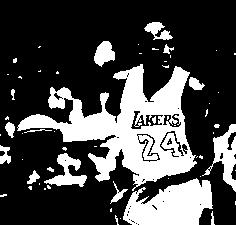

In [124]:
get_resp = requests.get(base_url + post_resp.json()['url'])
assert get_resp.ok, get_resp.reason
Image.open(io.BytesIO(r.content))